# Web Scraping & Predicting

In this project, we will practice two major skills. Collecting data by scraping a website and building a binary predictor with Logistic Regression.

### Step 1: Scrape your site

We will be scraping your website using BeautifulSoup. Write your code below.

In [1]:
import requests
import urllib2
import bs4
from bs4 import BeautifulSoup
import pandas as pd

import dota2api
api = dota2api.Initialise("4582834FCDCE8F18B5CFBF25D9213BB0")

acct_id = 76561198110813546
# given stats of a completed game, predict who won


In [3]:
# Started trying to use my own data, but the dota 2 api limits results to 500 per day.. couldn't get over a thousand.
# I found some joinDOTA league ID's to filter by to get over 1000 matches
league_ids = [2517,2854,3552,4038,4356,4688,1640,1175]
match_ids = []

for ID in league_ids:
    hist = api.get_match_history(league_id=ID)
    first = True
    while hist['results_remaining'] > 0:
        if first:
            first = False
        else:
            last_id = match_ids[len(match_ids) - 1]
            hist = api.get_match_history(start_at_match_id=last_id)
            
        for match in hist['matches']:
            match_ids.append(match['match_id'])
        
            
#check for repeats
print max(pd.Series(match_ids).value_counts())
#length over 1000
print len(match_ids)

1
1020


In [7]:
# get_match_details returns the match data that I need
matches = {}
count = 0
for ID in match_ids:
    matches[ID] = api.get_match_details(match_id=ID)
    count += 1
    # progress bar
    if not count % 100:
        print count

100
200
300
400
500
600
700
800
900
1000


In [8]:
# over 1k!
print len(matches)

1020


### Write functions to extract the features you think correlate well with your dataset. You MUST have at least 4 features!

- **Make sure these functions are robust and can handle cases where fields may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [164]:
# Match info
# radiant_win
# tower_status_radiant    - Status of Radiant towers
# tower_status_dire       - Status of Dire towers
# barracks_status_radiant - Status of Radiant barracks
# barracks_status_dire    - Status of Dire barracks
#     first_blood_time 

# player info
#  hero_id             - Unique hero ID
#         hero_name           - Hero's name
#         item_#              - Item ID for item in slot # (0-5)
#         item_#_name         - Item name for item in slot # (0-5)
#         kills               - Number of kills by player
#         deaths              - Number of player deaths
#         assists             - Number of player assists
#         leaver_status       - Connection/leaving status of player
#         gold                - Gold held by player
#         last_hits           - Number of last hits by player (creep score)
#         denies              - Number of denies
#         gold_per_min        - Average gold per minute
#         xp_per_min          - Average XP per minute
#         gold_spent          - Total amount of gold spent
#         hero_damage         - Amount of hero damage dealt by player
#         tower_damage        - Amount of tower damage dealt by player
#         hero_healing        - Amount of healing done by player
#         level               - Level of player's hero


dicty = {
    
    'radiant_wins' : [],
    'dire_gpm' : [],
    'radiant_gpm' : [],
    'dire_xpm' : [],
    'radiant_xpm' : [],
    'dire_assists' : [],
    'radiant_assists' : [],
    'dire_deaths' : [],
    'radiant_deaths' : [],
    'dire_kills' : [],
    'radiant_kills' : [],
    'dire_hero_ids' : [],
    'radiant_hero_ids' : [],
    #'match_id' : []
}

for match in matches:
    dicty['radiant_wins'] += [int(matches[match]['radiant_win'])]
    #dicty['match_id'] += [matches[match]['match_id']]
    temp_gpm = []
    temp_xpm = []
    temp_assists = []
    temp_kills = []
    temp_deaths = []
    temp_hero_id = []
    
    for player in matches[match]['players']:
        temp_gpm += [player['gold_per_min']]
        temp_xpm += [player['xp_per_min']]
        temp_assists += [player['assists']]
        temp_kills += [player['kills']]
        temp_deaths += [player['deaths']]
        temp_hero_id += [player['hero_id']]
        
    dicty['dire_gpm'] += [sum(temp_gpm[5:])]
    dicty['radiant_gpm'] += [sum(temp_gpm[:5])]
    dicty['dire_xpm'] += [sum(temp_xpm[5:])]
    dicty['radiant_xpm'] += [sum(temp_xpm[:5])]
    dicty['dire_assists'] += [sum(temp_assists[5:])]
    dicty['radiant_assists'] += [sum(temp_assists[:5])]
    dicty['dire_deaths'] += [sum(temp_deaths[5:])]
    dicty['radiant_deaths'] += [sum(temp_deaths[:5])]
    dicty['dire_kills'] += [sum(temp_kills[5:])]
    dicty['radiant_kills'] += [sum(temp_kills[:5])]
    dicty['dire_hero_ids'] += [temp_hero_id[5:]]
    dicty['radiant_hero_ids'] += [temp_hero_id[:5]]

### Make sure you have at least 1000 rows before continuing.

#### Clean up / standardize your data here

- Dates converted to correct format
- Remove dollar signs, spaces, periods
- etc

In [165]:
# No formatting needed, data came out clean.
for key in dicty:
    print len(dicty[key])

1020
1020
1020
1020
1020
1020
1020
1020
1020
1020
1020
1020
1020


### Create a dataframe to compile the results of your data cleaning.

In [166]:
scrape = pd.DataFrame(dicty)
scrape.head()

,dire_assists,dire_deaths,dire_gpm,dire_hero_ids,dire_kills,dire_xpm,radiant_assists,radiant_deaths,radiant_gpm,radiant_hero_ids,radiant_kills,radiant_wins,radiant_xpm
0,0,0,740,"[0, 0, 0, 17, 0]",0,0,0,0,595,"[0, 0, 112, 106, 55]",0,0,0
1,46,10,2470,"[106, 11, 28, 66, 86]",25,1937,13,26,1486,"[7, 101, 93, 88, 39]",9,0,1368
2,67,21,2183,"[86, 72, 79, 101, 2]",44,2438,36,45,1586,"[39, 50, 7, 55, 106]",21,0,1653
3,60,37,1787,"[79, 72, 25, 7, 11]",29,1954,70,30,1959,"[4, 86, 100, 59, 26]",37,1,2110
4,95,67,2388,"[15, 79, 55, 103, 48]",42,2161,121,43,2076,"[112, 35, 65, 26, 16]",65,0,2598


### Fill all the empty values with the column means or remove the rows from your table depending on your circumstances

In [272]:
# Games with 0 kills for BOTH teams are definitely 'practice' games and need to be taken out.
scrape = scrape[(scrape['radiant_kills'] != 0) & (scrape['dire_kills'] != 0)]
scrape.head()

,dire_assists,dire_deaths,dire_gpm,dire_hero_ids,dire_kills,dire_xpm,radiant_assists,radiant_deaths,radiant_gpm,radiant_hero_ids,radiant_kills,radiant_wins,radiant_xpm
1,46,10,2470,"[106, 11, 28, 66, 86]",25,1937,13,26,1486,"[7, 101, 93, 88, 39]",9,0,1368
2,67,21,2183,"[86, 72, 79, 101, 2]",44,2438,36,45,1586,"[39, 50, 7, 55, 106]",21,0,1653
3,60,37,1787,"[79, 72, 25, 7, 11]",29,1954,70,30,1959,"[4, 86, 100, 59, 26]",37,1,2110
4,95,67,2388,"[15, 79, 55, 103, 48]",42,2161,121,43,2076,"[112, 35, 65, 26, 16]",65,0,2598
5,15,32,1358,"[39, 44, 13, 100, 3]",8,1369,59,11,2291,"[107, 20, 22, 41, 72]",30,1,2005
6,58,29,2363,"[86, 102, 69, 106, 46]",32,2527,46,32,1653,"[1, 100, 3, 101, 11]",29,0,1796
7,50,42,1867,"[26, 99, 72, 14, 100]",23,2001,71,26,2583,"[3, 11, 52, 15, 66]",42,1,2729
8,53,23,2387,"[112, 56, 17, 25, 51]",33,2589,38,33,1715,"[30, 72, 75, 16, 50]",21,0,1928
9,33,33,1860,"[86, 53, 67, 111, 74]",14,1541,62,15,2546,"[85, 20, 39, 27, 63]",33,1,2226
10,28,28,1679,"[77, 20, 16, 76, 30]",17,1643,70,18,2559,"[37, 13, 53, 80, 87]",28,1,2174


### Save your results as a CSV

In [168]:
scrape.to_csv('dota_stats.csv', sep='\t')

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped

In [248]:
# was wanting to compare hero picks to player lifetime stats but could not get player info
dota = scrape.drop(['radiant_hero_ids','dire_hero_ids'], axis = 1)
dota['gpm_diff'] = dota['radiant_gpm'] - dota['dire_gpm']
dota['xpm_diff'] = dota['radiant_xpm'] - dota['dire_xpm']
dota['radiant_kda'] = (dota['radiant_kills'] + dota['radiant_assists']) / dota['radiant_deaths']
dota['dire_kda'] = (dota['dire_kills'] + dota['dire_assists']) / dota['dire_deaths']

# some correlate very highly with eachother, dropping to reduce redundancy
dota = dota.drop(['dire_kills','dire_deaths'], axis = 1)

#the difference in gpm/xpm correlates better than the separate gpm/xpm so drop them
dota = dota.drop(['radiant_xpm','radiant_gpm','dire_xpm','dire_gpm'], axis = 1)


dota.head()

,dire_assists,radiant_assists,radiant_deaths,radiant_kills,radiant_wins,gpm_diff,xpm_diff,radiant_kda,dire_kda
1,46,13,26,9,0,-984,-569,0.846154,7.100000
2,67,36,45,21,0,-597,-785,1.266667,5.285714
3,60,70,30,37,1,172,156,3.566667,2.405405
4,95,121,43,65,0,-312,437,4.325581,2.044776
5,15,59,11,30,1,933,636,8.090909,0.718750


### We want to predict whether the target was in a range or not with a binary variable. Create binary variables for some of your non-binary features, so we can draw correlations. See the logisitic regression lab if you are having trouble understanding the instructions. 

In [249]:
#all of my end game features correlate
dota.corr()

,dire_assists,radiant_assists,radiant_deaths,radiant_kills,radiant_wins,gpm_diff,xpm_diff,radiant_kda,dire_kda
dire_assists,1.000000,0.252630,0.923735,0.195926,-0.504596,-0.475720,-0.522175,-0.499594,0.332142
radiant_assists,0.252630,1.000000,0.222358,0.914259,0.429069,0.416334,0.486014,0.247427,-0.561580
radiant_deaths,0.923735,0.222358,1.000000,0.192657,-0.557150,-0.532864,-0.583043,-0.559240,0.316321
radiant_kills,0.195926,0.914259,0.192657,1.000000,0.511571,0.519326,0.583890,0.267605,-0.637243
radiant_wins,-0.504596,0.429069,-0.557150,0.511571,1.000000,0.859005,0.862194,0.566555,-0.650696
gpm_diff,-0.475720,0.416334,-0.532864,0.519326,0.859005,1.000000,0.906723,0.600809,-0.699616
xpm_diff,-0.522175,0.486014,-0.583043,0.583890,0.862194,0.906723,1.000000,0.627893,-0.731181
radiant_kda,-0.499594,0.247427,-0.559240,0.267605,0.566555,0.600809,0.627893,1.000000,-0.524296
dire_kda,0.332142,-0.561580,0.316321,-0.637243,-0.650696,-0.699616,-0.731181,-0.524296,1.000000


### Thought experiment: What is the baseline accuracy for this model?

In [250]:
print "Baseline Accuracy"
print float(sum(dota['radiant_wins'])) / float(len(dota['radiant_wins']))
#dire has a slight advantage

Baseline Accuracy
0.490316004077


### Create a Logistic Regression model to predict your target using statsmodel. Start by ONLY using one feature. Display the coefficients and write a short summary of what each feature means.

In [256]:
import statsmodels.formula.api as sm

model = sm.logit(
    "radiant_wins ~ radiant_kills + radiant_deaths + radiant_assists",
    data = dota
).fit()
model.summary()

# FEATURE SUMMARY
# Radiant wins is the target
# <team>_assists : total number of assists in the game based on the number of players that dealt damage to the target
# <team>_kills: total kills for that team
# <team>_deaths: total deaths for that team
# <team>_kda: (kills + assists) / deaths, for the team
# gpm_diff: radiant_gpm - dire_gpm
# xpm_diff: radiant_xpm - dire_xpm


Optimization terminated successfully.
         Current function value: 0.165686
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           radiant_wins   No. Observations:                  981
Model:                          Logit   Df Residuals:                      977
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Oct 2016   Pseudo R-squ.:                  0.7609
Time:                        18:24:59   Log-Likelihood:                -162.54
converged:                       True   LL-Null:                       -679.79
                                        LLR p-value:                5.870e-224
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.6929      0.427      1.623      0.105        -0.144     1.530
radiant_kills       0.3278      0.035      9.489      0.000         0.260     0.396
radiant_deaths     -0.3067      0.023    -13.585      0.000        -0.351    -0.262
radiant_assists    -0.0159      0.014     -1.178      0.239        -0.042     0.011
===================================================================================
"""

#### Create a few new variables in your dataframe to represent interesting aspects of your features.
- For example, create a feature that represents whether 'Senior' is in the title when dealing with employment statistics
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [257]:
# I created KDA and GPM/XPM diff above for this part
model = sm.logit(
    "radiant_wins ~ radiant_kda + gpm_diff + xpm_diff",
    data = dota
).fit()
model.summary()

# It seems to me that the radiant kda coef is stronger than the combination from before.

Optimization terminated successfully.
         Current function value: 0.047855
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           radiant_wins   No. Observations:                  981
Model:                          Logit   Df Residuals:                      977
Method:                           MLE   Df Model:                            3
Date:                Sun, 30 Oct 2016   Pseudo R-squ.:                  0.9309
Time:                        18:25:29   Log-Likelihood:                -46.946
converged:                       True   LL-Null:                       -679.79
                                        LLR p-value:                4.086e-274
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      -2.0069      1.083     -1.852      0.064        -4.130     0.117
radiant_kda     0.8195      0.360      2.278      0.023         0.114     1.525
gpm_diff        0.0134      0.002      7.279      0.000         0.010     0.017
xpm_diff        0.0004      0.001      0.348      0.728        -0.002     0.003
===============================================================================
"""

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [265]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = dota.drop("radiant_wins", axis = 1)
y = dota['radiant_wins']

logreg = LogisticRegression(random_state=77)
logreg.fit(X, y)
Y_pred = logreg.predict(X)

# cnf matrix of predicted values and actual values
conmat = np.array(confusion_matrix(y, Y_pred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['is_radiant', 'not_radiant'],
                     columns=['predicted_radiant','predicted_not_radiant'])

print(confusion)

             predicted_radiant  predicted_not_radiant
is_radiant                 469                     12
not_radiant                  5                    495


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

             precision    recall  f1-score   support

          0       0.98      0.99      0.98       500
          1       0.99      0.98      0.98       481

avg / total       0.98      0.98      0.98       981



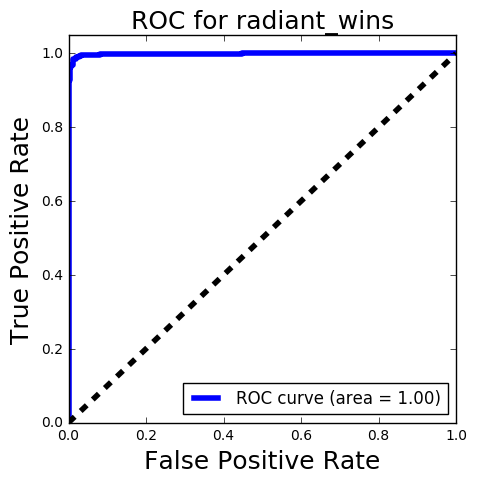

In [268]:
Y_proba_score = logreg.predict_proba(X)

FPR, TPR, thresholds = roc_curve(y, Y_proba_score[:,1])
print(classification_report(y, Y_pred))

def examine_coefficients(logreg, df):
    return pd.DataFrame(
        { 'Coefficient' : logreg.coef_[0] , 'Feature' : df.columns}
    ).sort_values(by='Coefficient')

examine_coefficients(logreg, X)

ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for radiant_wins
plt.figure(figsize=[5,5])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC for radiant_wins', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [269]:
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X, y)
Y_score = logreg.decision_function(X)
Y_proba_score = logreg.predict_proba(X)
# For class 1, find the area under the curve
FPR, TPR, thresholds = roc_curve(y, Y_proba_score[:,1])
ROC_AUC = auc(FPR, TPR)
print ROC_AUC
print examine_coefficients(logreg, X)

0.998187110187
   Coefficient          Feature
2    -0.031083   radiant_deaths
0    -0.010346     dire_assists
7     0.000000         dire_kda
5     0.000288         xpm_diff
1     0.006106  radiant_assists
4     0.013492         gpm_diff
3     0.019740    radiant_kills
6     0.409215      radiant_kda


In [271]:
logreg = LogisticRegression(penalty='l2', solver='liblinear')
logreg.fit(X, y)
Y_score = logreg.decision_function(X)
Y_proba_score = logreg.predict_proba(X)
# For class 1, find the area under the curve
FPR, TPR, thresholds = roc_curve(y, Y_proba_score[:,1])
ROC_AUC = auc(FPR, TPR)
print ROC_AUC
print examine_coefficients(logreg, X)


# L1 vs L2 doesn't change much for my model. my coef's change, some going up, some going down.

0.998191268191
   Coefficient          Feature
2    -0.046839   radiant_deaths
0    -0.011526     dire_assists
5     0.000265         xpm_diff
7     0.005057         dire_kda
4     0.013463         gpm_diff
6     0.014930      radiant_kda
3     0.023442    radiant_kills
1     0.028289  radiant_assists


#### Continue to incorporate other text features that you believe will predict the salary and examine their coefficients

#### Scrape more entries pertaining to your data. Convert them to use with your model and predict the target. 

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from text summaries if they exist. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE

In [ ]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [ ]:
## YOUR CODE HERE